In [1]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd

In [2]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [3]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# ÂÆö‰πâÂõ†Â≠êÔºÅ

In [22]:
def factor(df, window_size = 960, threshold_value = 0.2):
    """
    ‰ºòÂåñÂêéÁöÑËÅ™ÊòéÈí±Âõ†Â≠êËÆ°ÁÆó (ÊîØÊåÅÂõõÁßçÊñ∞ÁöÑSÂÄºÊûÑÈÄ†ÊñπÂºè)
    ‰ºòÂåñÁÇπ:
    1. È¢ÑËÆ°ÁÆóÊâÄÊúâÂøÖË¶ÅÂàóÔºàÈÅøÂÖçÈáçÂ§çËÆ°ÁÆóÔºâ
    2. ‰ΩøÁî®ÊªöÂä®Á™óÂè£ÂêëÈáèÂåñÊìç‰Ωú
    3. ‰ΩøÁî®numpyÊõø‰ª£pandasËøõË°åÁ™óÂè£ÂÜÖËÆ°ÁÆó
    4. ÈÅøÂÖçÂú®Âæ™ÁéØ‰∏≠ÂàõÂª∫‰∏¥Êó∂Series
    
    Êñ∞Â¢ûÂõõÁßçSÂÄºÊûÑÈÄ†ÊñπÂºè:
    1. S = |R| / (V √ó œÉ·µ•)   (Êàê‰∫§ÈáèÊ≥¢Âä®ÁéáË∞ÉÊï¥)
    2. S = |R| √ó (taker_buy_volume / volume)  (‰∏ªÂä®‰π∞ÂÖ•ÊØî‰æã)
    3. S = |R| / ‚àö(trade_count)  (‰∫§ÊòìÁ¨îÊï∞Ë∞ÉÊï¥)
    4. S = |R| √ó e^(-Œ≤/V)   (ÊåáÊï∞Ë°∞ÂáèÂáΩÊï∞)
    """
    # ========== ÈÄâÊã©Ë¶Å‰ΩøÁî®ÁöÑSÂÄºËÆ°ÁÆóÊñπÊ≥ï (‰øÆÊîπËøôÈáåÁöÑÊï∞Â≠óÂç≥ÂèØÂàáÊç¢) ==========
    S_METHOD = 2  # ÂèØÈÄâÂÄº: 1, 2, 3, 4
    
    # È¢ÑËÆ°ÁÆóÊâÄÊúâÂøÖË¶ÅÂÄº
    avg_price = (df['open'] + df['high'] + df['low'] + df['close']) / 4
    avg_price_vals = avg_price.values
    
    abs_ret = abs((df['close'] - df['open']) / df['open'])
    volume = df['volume'].values
    
    # ========== Ê†πÊçÆÈÄâÊã©ÁöÑÊñπÊ≥ïËÆ°ÁÆóSÂÄº ==========
    if S_METHOD == 1:
        # ÊñπÊ≥ï1: S = |R| / (V √ó œÉ·µ•)
        # ËÆ°ÁÆóÊàê‰∫§ÈáèÊ≥¢Âä®Áéá (20ÊúüÊ†áÂáÜÂ∑Æ)
        vol_std = df['volume'].rolling(20, min_periods=1).std().shift(1).fillna(0.001)
        S_values = abs_ret.values / (volume * vol_std.values + 1e-9)  # ÈÅøÂÖçÈô§Èõ∂
    
    elif S_METHOD == 2:
        # ÊñπÊ≥ï2: S = |R| √ó (taker_buy_volume / volume)
        # ËÆ°ÁÆó‰∏ªÂä®‰π∞ÂÖ•ÊØî‰æã
        buy_ratio = df['taker_buy_volume'] / (df['volume'] + 1e-9)
        S_values = abs_ret.values * buy_ratio.values
    
    elif S_METHOD == 3:
        # ÊñπÊ≥ï3: S = |R| / ‚àö(trade_count)
        # ‰ΩøÁî®‰∫§ÊòìÁ¨îÊï∞
        sqrt_trade = np.sqrt(df['trade_count'])
        S_values = abs_ret.values / (sqrt_trade.values + 1e-9)  # ÈÅøÂÖçÈô§Èõ∂
    
    elif S_METHOD == 4:
        # ÊñπÊ≥ï4: S = |R| √ó e^(-Œ≤/V)
        # Œ≤ÂèÇÊï∞ËÆæÁΩÆ (Êé®ËçêËåÉÂõ¥0.5-2)
        beta = 1.0  
        # ÊåáÊï∞Ë°∞ÂáèËÆ°ÁÆó (ÂØπÂ∞èÊàê‰∫§ÈáèÊõ¥ÊïèÊÑü)
        exp_factor = np.exp(-beta / (volume + 1e-9))  # ÈÅøÂÖçÈô§Èõ∂
        S_values = abs_ret.values * exp_factor
    
    else:
        raise ValueError("Êó†ÊïàÁöÑS_METHODÂÄºÔºåÂøÖÈ°ªÊòØ1-4")
    
    # ÂàùÂßãÂåñÂõ†Â≠êÂÄºÊï∞ÁªÑ
    factor_values = np.full(len(df), np.nan)
    
    # ‰ΩøÁî®ÊªëÂä®Á™óÂè£ËÆ°ÁÆó
    for i in range(window_size, len(df)):
        # Ëé∑ÂèñÂΩìÂâçÁ™óÂè£ÂàáÁâáÁ¥¢Âºï
        start_idx = i - window_size
        end_idx = i - 1
        
        # ÊèêÂèñÂΩìÂâçÁ™óÂè£Êï∞ÊçÆ
        window_avg_price = avg_price_vals[start_idx:end_idx]
        window_volume = volume[start_idx:end_idx]
        window_S = S_values[start_idx:end_idx]
        
        # ÊåâSÂÄºÈôçÂ∫èÊéíÂ∫èÁöÑÁ¥¢Âºï
        sorted_idx = np.argsort(-window_S)
        sorted_volume = window_volume[sorted_idx]
        sorted_avg_price = window_avg_price[sorted_idx]
        
        # ËÆ°ÁÆóÁ¥ØÁßØÊàê‰∫§Èáè
        cum_volume = np.cumsum(sorted_volume)
        total_volume = cum_volume[-1]
        threshold = total_volume * threshold_value
        
        # ÊâæÂà∞ËÅ™ÊòéÈí±‰∫§ÊòìÁÇπ (Ââç20%Êàê‰∫§Èáè)
        smart_mask = cum_volume <= threshold
        if np.any(smart_mask):
            smart_vwap = np.sum(sorted_avg_price[smart_mask] * 
                               sorted_volume[smart_mask]) / np.sum(sorted_volume[smart_mask])
        else:
            smart_vwap = np.nan
        
        # ËÆ°ÁÆóÊï¥‰ΩìVWAP
        all_vwap = np.sum(window_avg_price * window_volume) / np.sum(window_volume)
        
        # ËÆ°ÁÆóÂõ†Â≠êÂÄº
        if not np.isnan(smart_vwap) and all_vwap != 0:
            factor_values[i] = smart_vwap / all_vwap
            
    return pd.Series(factor_values, index=df.index)

# ÊµãËØïÂõ†Â≠êË°®Áé∞


üìä ÂçïÂ∏ÅÁßç (single) ËØ¶ÁªÜËØÑ‰º∞ÁªìÊûú:
--------------------------------------------------
üîó Áõ∏ÂÖ≥ÊÄßÂàÜÊûê:
   IC (Pearson): 0.014563
   Rank_IC (Spearman): 0.020014
üìä ‰ø°ÊÅØÊØîÁéá:
   IR: -0.271804
   ÊúâÊïàÂàÜÁªÑÊï∞: 10
üìä Âõ†Â≠êÂàÜÂ∏É:
üìã Êï∞ÊçÆÊ¶ÇÂÜµ:
   Êï∞ÊçÆÈïøÂ∫¶: 127195
   Âõ†Â≠êÂàó: factor
   Êî∂ÁõäÁéáÂàó: future_return
   Êú™Êù•Êî∂ÁõäÂë®Êúü: 10
--------------------------------------------------

üñºÔ∏è  ÂçïÂ∏ÅÁßç (single) ÂõæÁâáÂ±ïÁ§∫:
----------------------------------------
üìä ÊòæÁ§∫ÂàÜÁªÑÂàÜÊûêÂõæ...


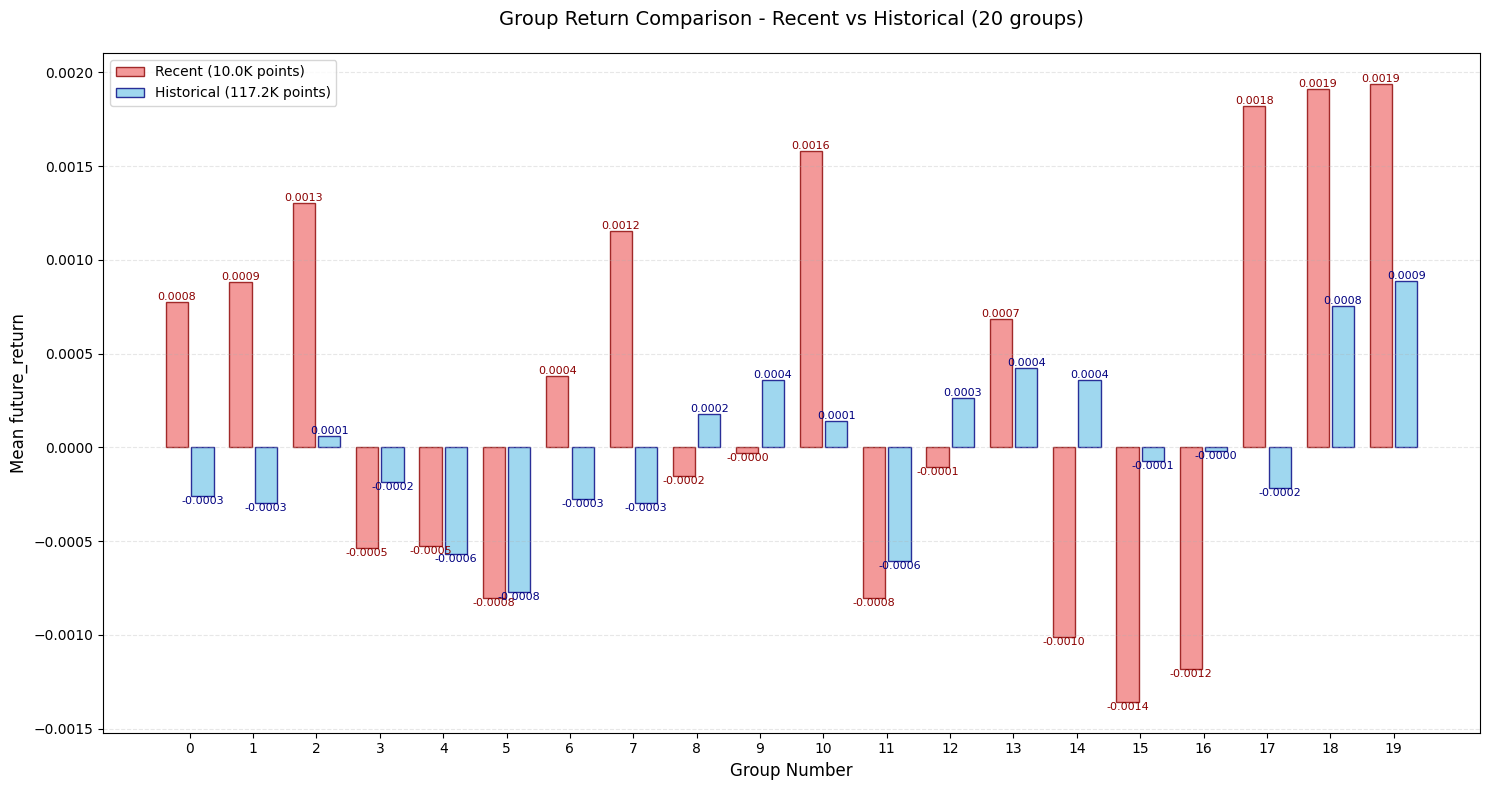

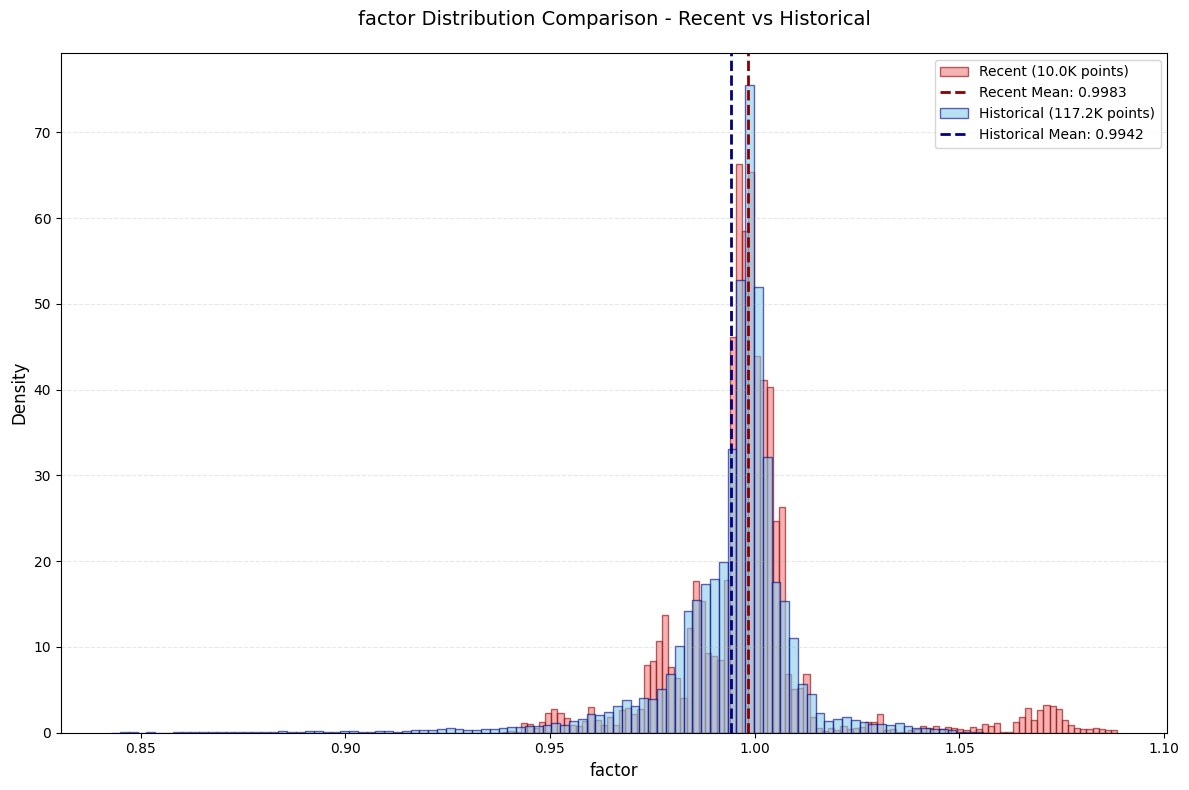

üìà ÊòæÁ§∫Âõ†Â≠êÂàÜÂ∏ÉÂõæ...
‚úÖ Â∑≤ÊòæÁ§∫ 2 ‰∏™ÂõæÁâá
----------------------------------------


In [23]:
evaluator.set_factor(
    factor_func=lambda df: factor(df),
    factor_name='factor'
)

result=evaluator.run_full_evaluation(run_stationarity_test=False)

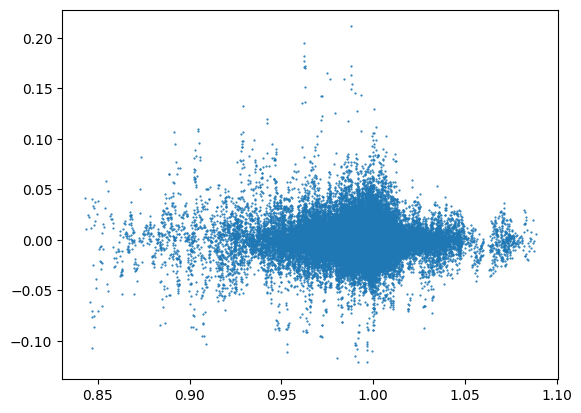

In [24]:
import matplotlib.pyplot as plt
plt.scatter(factor(df),df['close'].pct_change(-10), s=0.3)

In [25]:
result['information_ratio']['group_correlations']
# ËøôË°®Á§∫‰∏çÂêåÂàÜÁªÑ‰πãÈó¥ÁöÑÁõ∏ÂÖ≥ÊÄßÔºåÈÄöÂ∏∏Áî®‰∫éËØÑ‰º∞Âõ†Â≠êÂú®‰∏çÂêåÂ∏ÇÂú∫Áä∂ÊÄÅ‰∏ãÁöÑË°®Áé∞‰∏ÄËá¥ÊÄß„ÄÇ
# Â¶ÇÊûúÁõ∏ÂÖ≥ÊÄßËæÉÈ´òÔºåËØ¥ÊòéÂõ†Â≠êÂú®‰∏çÂêåÂ∏ÇÂú∫Áä∂ÊÄÅ‰∏ãË°®Áé∞‰∏ÄËá¥ÔºõÂ¶ÇÊûúÁõ∏ÂÖ≥ÊÄßËæÉ‰ΩéÔºåËØ¥ÊòéÂõ†Â≠êÂú®‰∏çÂêåÂ∏ÇÂú∫Áä∂ÊÄÅ‰∏ãË°®Áé∞Â∑ÆÂºÇËæÉÂ§ß„ÄÇ

[-0.01740476984099544,
 0.00031165443399808706,
 -0.004617670303204183,
 -0.004192726190731877,
 -0.01204703375763136,
 -0.04641762438986431,
 0.01645459278159373,
 -0.026832799575998836,
 0.008779871371771036,
 0.029746619447179184]

In [26]:
print(result)

{'correlation_analysis': {'IC': 0.014562944577382407, 'Rank_IC': 0.020014179888072157}, 'information_ratio': {'IR': -0.27180355160618347, 'group_correlations': [-0.01740476984099544, 0.00031165443399808706, -0.004617670303204183, -0.004192726190731877, -0.01204703375763136, -0.04641762438986431, 0.01645459278159373, -0.026832799575998836, 0.008779871371771036, 0.029746619447179184], 'n_groups': 10}, 'group_analysis': {'group_stats':        val_min  val_max  val_mean  return_mean  return_std  count
group                                                            
0       0.8428   0.9660    0.9434      -0.0002      0.0222   6360
1       0.9660   0.9783    0.9729      -0.0002      0.0149   6360
2       0.9783   0.9838    0.9814       0.0002      0.0126   6360
3       0.9838   0.9870    0.9854      -0.0003      0.0117   6359
4       0.9870   0.9899    0.9884      -0.0005      0.0125   6360
5       0.9899   0.9927    0.9913      -0.0008      0.0128   6360
6       0.9927   0.9946    0.9937  